# <center>Classification Project</center>

Prepared by:
- Ayetijhya Desmukhya
- Assyl Salah

### Overview

`job_change` for classification

Our task is to apply various ML algorithms (see the rules below) to build a model explaining whether a particular person is willing to change job based on the training sample and generate predictions for all observations from the test sample.

The dataset includes 12427 observations in the training sample and 3308 in the test sample and the following columns:
- `id` – unique observation identifier
- `gender` – gender of a person
- `age` – age of a person in years
- `education` – highest formal education level of a person attained so far
- `field_of_studies` – field of studies of a person
- `is_studying` – information whether a person is currently studying
- `county` – county code in which the person currently lives and works
- `relative_wage` – relative wage in the county (as percentage of country average)
- `years_since_job_change` – years since a person last changed the job
- `years_of_experience` – total number of years of professional experience of a person
- `hours_of_training` – total number of training hours completed by a person
- `is_certified` – does a person have any formal certificate of completed trainings
- `size_of_company` – size of a company in which a person currently works
- `typs_of_company` – type of a company in which a person currently works
- `willing_to_change_job` – is a person willing to change job (outcome variable, only in the training sample)

In [62]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

#Scaling
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", 500)
np.random.seed(2002)

### Dataset Preparation

In [2]:
# Load train dataset
job_change_data_train = pd.read_csv('data\job_change_train.csv')
job_change_data_train.head()

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
0,1,Male,22,higher_BSc,science,no,county_118,162.84,1,2,18,1,<10,private_company,No
1,2,Male,27,higher_BSc,science,no,county_028,151.34,1,6,24,1,50-99,private_company,No
2,3,Male,38,higher_BSc,science,no,county_031,114.17,1,13,96,1,50-99,startup_with_funding,No
3,4,Unknown,47,higher_BSc,science,no,county_080,123.55,>4,>20,36,1,100-500,private_company,No
4,5,Male,28,higher_BSc,science,no,county_118,162.84,1,5,106,1,1000-4999,private_company,No


In [3]:
# Load test dataset
job_change_data_test = pd.read_csv('data\job_change_test.csv')
job_change_data_test.head()

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company
0,12428,Male,32,higher_BSc,science,no,county_053,166.20,4,9,22,1,10000+,private_company
1,12429,Male,33,higher_BSc,science,no,county_005,153.10,2,9,152,1,50-99,private_company
2,12430,Male,36,higher_BSc,science,no,county_059,110.45,>4,17,23,0,10000+,private_company
3,12431,Male,30,higher_MSc,science,no,county_118,162.84,1,10,21,1,10000+,private_company
4,12432,Male,33,higher_MSc,science,no,county_110,163.90,2,10,15,1,500-999,private_company


### Data Inspection

In [4]:
# Check for data information
job_change_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12427 entries, 0 to 12426
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      12427 non-null  int64  
 1   gender                  12427 non-null  object 
 2   age                     12427 non-null  int64  
 3   education               12427 non-null  object 
 4   field_of_studies        12427 non-null  object 
 5   is_studying             12427 non-null  object 
 6   county                  12427 non-null  object 
 7   relative_wage           12427 non-null  float64
 8   years_since_job_change  12427 non-null  object 
 9   years_of_experience     12427 non-null  object 
 10  hours_of_training       12427 non-null  int64  
 11  is_certified            12427 non-null  int64  
 12  size_of_company         12427 non-null  object 
 13  type_of_company         12427 non-null  object 
 14  willing_to_change_job   12427 non-null

In [5]:
# Checking for missing data - no missing data found
job_change_data_train.isnull().sum()

id                        0
gender                    0
age                       0
education                 0
field_of_studies          0
is_studying               0
county                    0
relative_wage             0
years_since_job_change    0
years_of_experience       0
hours_of_training         0
is_certified              0
size_of_company           0
type_of_company           0
willing_to_change_job     0
dtype: int64

In [6]:
# Check if data is duplicated
job_change_data_train.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
12422    False
12423    False
12424    False
12425    False
12426    False
Length: 12427, dtype: bool

In [7]:
# Categorical columns
cat_col = [col for col in job_change_data_train.columns if job_change_data_train[col].dtype == 'object']
print('Categorical columns :',cat_col)
# Numerical columns
num_col = [col for col in job_change_data_train.columns if job_change_data_train[col].dtype != 'object']
print('Numerical columns :',num_col)

Categorical columns : ['gender', 'education', 'field_of_studies', 'is_studying', 'county', 'years_since_job_change', 'years_of_experience', 'size_of_company', 'type_of_company', 'willing_to_change_job']
Numerical columns : ['id', 'age', 'relative_wage', 'hours_of_training', 'is_certified']


In [8]:
# Check possible values for categorical columns
unique_values_dict = {}
    
for col in cat_col:
    unique_values_dict[col] = job_change_data_train[col].unique().tolist()

unique_values_dict

{'gender': ['Male', 'Unknown', 'Female', 'Other'],
 'education': ['higher_BSc',
  'secondary',
  'higher_MSc',
  'Phd',
  'primary',
  'no_information'],
 'field_of_studies': ['science',
  'no_information',
  'other',
  'humanities',
  'business',
  'arts'],
 'is_studying': ['no', 'full_time', 'part_time', 'no_information'],
 'county': ['county_118',
  'county_028',
  'county_031',
  'county_080',
  'county_059',
  'county_117',
  'county_074',
  'county_049',
  'county_040',
  'county_018',
  'county_110',
  'county_022',
  'county_025',
  'county_075',
  'county_119',
  'county_092',
  'county_041',
  'county_121',
  'county_108',
  'county_053',
  'county_006',
  'county_020',
  'county_077',
  'county_019',
  'county_042',
  'county_081',
  'county_038',
  'county_029',
  'county_112',
  'county_086',
  'county_001',
  'county_068',
  'county_021',
  'county_116',
  'county_013',
  'county_093',
  'county_024',
  'county_102',
  'county_099',
  'county_058',
  'county_062',
  'coun

### Data Adjustment

In [9]:
# Changing all categorical columns into numerical ones as they might be significant features
# Define mapping dictionaries
mappings = {
    'gender': {'Unknown': -1, 'Male': 0, 'Female': 1, 'Other': 2},
    'education': {'no_information': -1, 'primary': 0, 'secondary': 1, 'higher_BSc': 2, 'higher_MSc': 3, 'Phd': 4},
    'field_of_studies': {'no_information': -1, 'science': 0, 'business': 1, 'humanities': 2, 'arts': 3, 'other': 4},
    'is_studying': {'no_information': -1, 'no': 0, 'part_time': 1, 'full_time': 2},
    'county': {f'county_{i:03d}': i for i in range(1, len(job_change_data_train['county'].unique())+1)},
    'years_since_job_change': {'unknown': -1, 'never_changed': 0, **{str(i): i for i in range(1, 5)}, '>4': 5},
    'years_of_experience': {'unknown': -1, '<1': 0, **{str(i): i for i in range(1, 21)}, '>20': 21},
    'size_of_company': {'unknown': -1, '<10': 0, '<10': 0, '10-49': 1, '50-99': 2, '100-500': 3, '500-999': 4, '1000-4999': 5, '5000-9999': 6, '10000+': 7},
    'type_of_company': {'no_information': -1, 'startup_wo_funding': 0, 'startup_with_funding': 1, 'private_company': 2, 'NGO': 3, 'public_sector': 4, 'other': 5},
    'willing_to_change_job': {'No': 0, 'Yes': 1}
}

# Apply mappings
for column, mapping in mappings.items():
    job_change_data_train[column] = job_change_data_train[column].map(mapping)
    if column != 'willing_to_change_job':
        job_change_data_test[column] = job_change_data_test[column].map(mapping)


In [39]:
cleaned_df = job_change_data_train[(job_change_data_train != -1).all(axis=1)]
cleaned_df.head()

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
0,1,0,22,2,0,0,118,162.84,1,2,18,1,0,2,0
1,2,0,27,2,0,0,28,151.34,1,6,24,1,2,2,0
2,3,0,38,2,0,0,31,114.17,1,13,96,1,2,1,0
4,5,0,28,2,0,0,118,162.84,1,5,106,1,5,2,0
5,6,0,25,2,0,0,59,110.45,1,3,43,1,7,2,1


### Initial Descriptive Analysis of Data

In [41]:
# Check statistics
round(cleaned_df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
id,5781.0,6189.48,3586.73,1.0,3109.00,6148.00,9257.00,12427.00
gender,5781.0,0.11,0.35,0.0,0.00,0.00,0.00,2.00
age,5781.0,34.51,8.05,20.0,28.00,33.00,40.00,50.00
education,5781.0,2.32,0.52,2.0,2.00,2.00,3.00,4.00
field_of_studies,5781.0,0.28,0.88,0.0,0.00,0.00,0.00,4.00
is_studying,5781.0,0.24,0.60,0.0,0.00,0.00,0.00,2.00
county,5781.0,81.15,35.41,1.0,59.00,75.00,118.00,123.00
relative_wage,5781.0,149.45,20.64,79.3,140.54,161.07,162.84,167.97
years_since_job_change,5781.0,2.35,1.67,0.0,1.00,2.00,4.00,5.00
years_of_experience,5781.0,11.65,6.56,0.0,6.00,10.00,18.00,21.00


### Target Variable Analysis

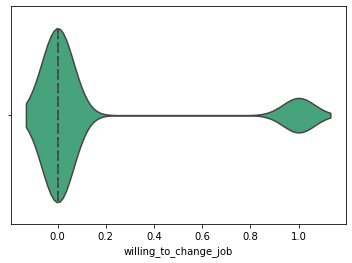

In [42]:
# Target Variable Distribution
sns.violinplot(x=cleaned_df['willing_to_change_job'], inner="quartile", color="#36B37E");

In [45]:
print(job_change_data_train.groupby("education")["willing_to_change_job"].describe())
print(cleaned_df.groupby("education")["willing_to_change_job"].describe())

            count      mean       std  min  25%  50%  75%  max
education                                                     
-1          295.0  0.216949  0.412868  0.0  0.0  0.0  0.0  1.0
 0          196.0  0.163265  0.370554  0.0  0.0  0.0  0.0  1.0
 1         1320.0  0.184091  0.387705  0.0  0.0  0.0  0.0  1.0
 2         7528.0  0.278826  0.448451  0.0  0.0  0.0  1.0  1.0
 3         2831.0  0.218297  0.413163  0.0  0.0  0.0  0.0  1.0
 4          257.0  0.120623  0.326324  0.0  0.0  0.0  0.0  1.0
            count      mean       std  min  25%  50%  75%  max
education                                                     
2          4055.0  0.175092  0.380093  0.0  0.0  0.0  0.0  1.0
3          1579.0  0.144395  0.351601  0.0  0.0  0.0  0.0  1.0
4           147.0  0.122449  0.328924  0.0  0.0  0.0  0.0  1.0


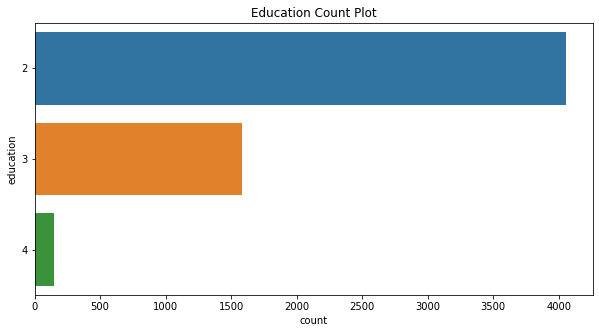

In [70]:
plt.figure(figsize=(10, 5))
sns.countplot(y="education", data=cleaned_df, orient="h").set(
    title="Education Count Plot", ylabel="education"
)
plt.show()

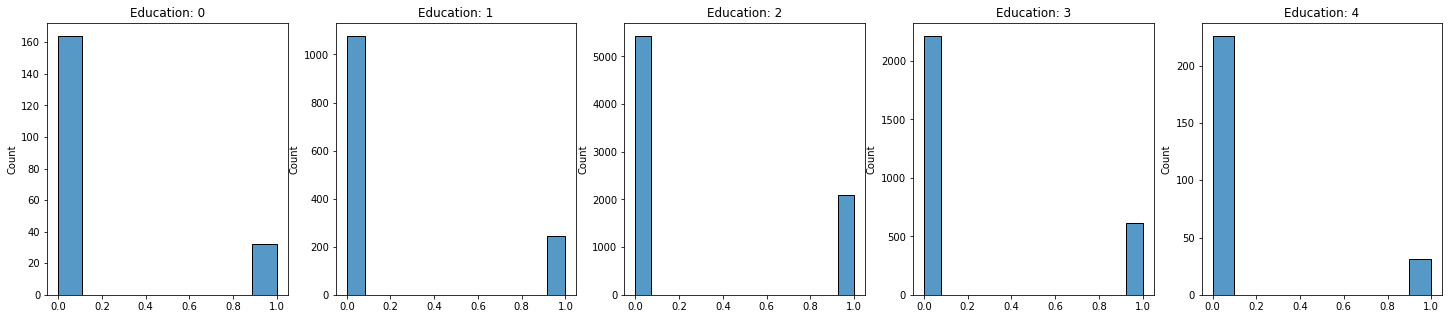

In [13]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(25,5))
for i, ax in zip(range(0, 6), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.education == i].willing_to_change_job, ax=ax).set(
        title=f"Education: {i}", xlabel=""
    )
plt.show()

In [47]:
print(job_change_data_train.groupby("size_of_company")["willing_to_change_job"].describe())
print(cleaned_df.groupby("size_of_company")["willing_to_change_job"].describe())

                  count      mean       std  min  25%  50%  75%  max
size_of_company                                                     
-1               3850.0  0.402857  0.490536  0.0  0.0  0.0  1.0  1.0
 0                854.0  0.154567  0.361703  0.0  0.0  0.0  0.0  1.0
 1                923.0  0.232936  0.422931  0.0  0.0  0.0  0.0  1.0
 2               2008.0  0.178287  0.382849  0.0  0.0  0.0  0.0  1.0
 3               1644.0  0.159976  0.366695  0.0  0.0  0.0  0.0  1.0
 4                582.0  0.175258  0.380514  0.0  0.0  0.0  0.0  1.0
 5                875.0  0.154286  0.361429  0.0  0.0  0.0  0.0  1.0
 6                362.0  0.190608  0.393324  0.0  0.0  0.0  0.0  1.0
 7               1329.0  0.197141  0.397989  0.0  0.0  0.0  0.0  1.0
                  count      mean       std  min  25%  50%  75%  max
size_of_company                                                     
0                 537.0  0.139665  0.346962  0.0  0.0  0.0  0.0  1.0
1                 593.0  0.188870 

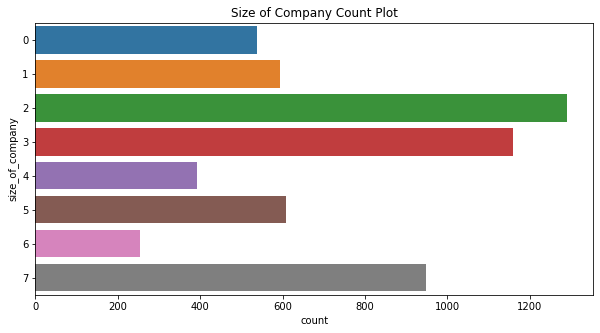

In [69]:
plt.figure(figsize=(10, 5))
sns.countplot(y="size_of_company", data=cleaned_df, orient="h").set(
    title="Size of Company Count Plot", ylabel="size_of_company"
)
plt.show()

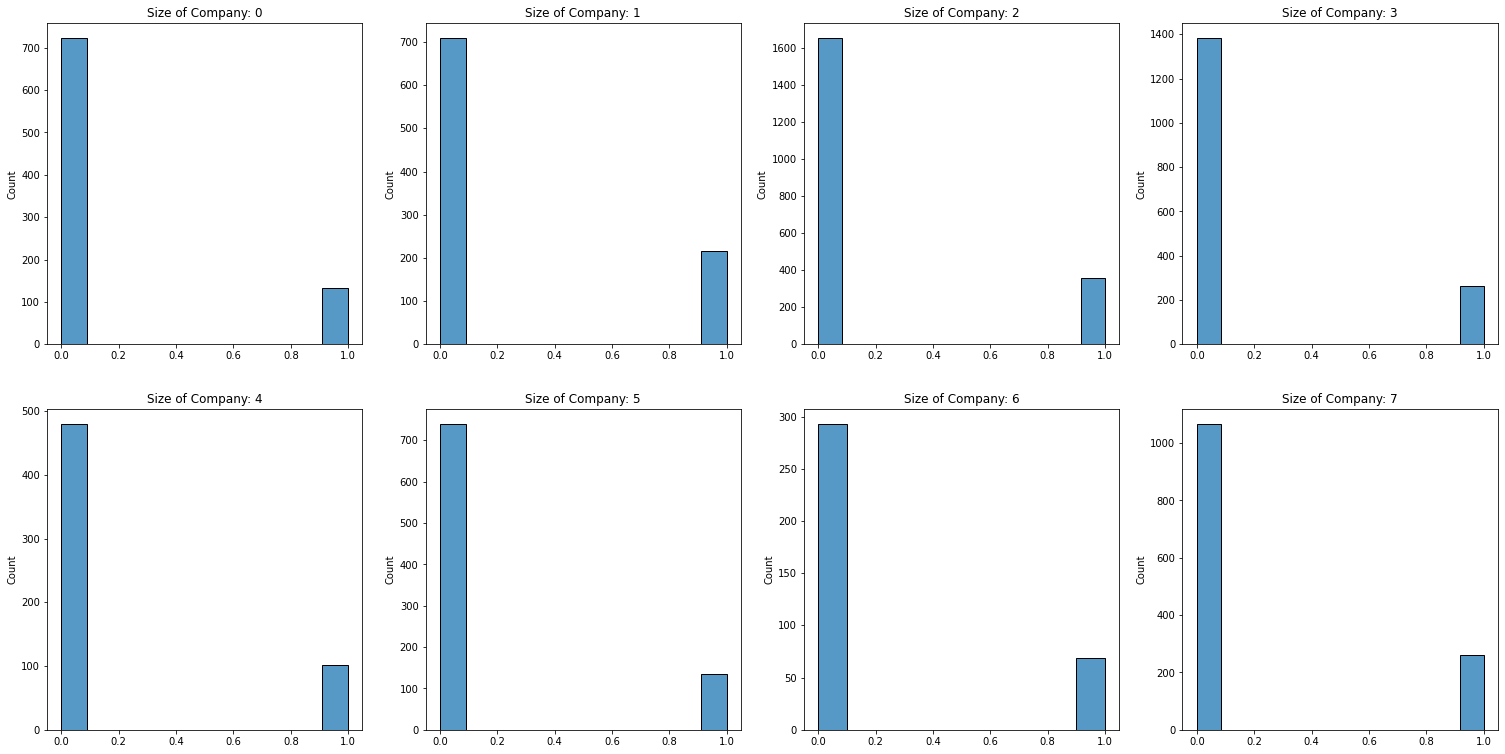

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(26,13))
for i, ax in zip(range(0, 8), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.size_of_company == i].willing_to_change_job, ax=ax).set(
        title=f"Size of Company: {i}", xlabel=""
    )
plt.show()

In [48]:
print(job_change_data_train.groupby("type_of_company")["willing_to_change_job"].describe())
print(cleaned_df.groupby("type_of_company")["willing_to_change_job"].describe())

                  count      mean       std  min  25%  50%  75%  max
type_of_company                                                     
-1               3995.0  0.386984  0.487121  0.0  0.0  0.0  1.0  1.0
 0                377.0  0.241379  0.428488  0.0  0.0  0.0  0.0  1.0
 1                655.0  0.143511  0.350862  0.0  0.0  0.0  0.0  1.0
 2               6372.0  0.178280  0.382778  0.0  0.0  0.0  0.0  1.0
 3                330.0  0.200000  0.400607  0.0  0.0  0.0  0.0  1.0
 4                613.0  0.220228  0.414739  0.0  0.0  0.0  0.0  1.0
 5                 85.0  0.223529  0.419083  0.0  0.0  0.0  0.0  1.0
                  count      mean       std  min  25%  50%  75%  max
type_of_company                                                     
0                 227.0  0.193833  0.396173  0.0  0.0  0.0  0.0  1.0
1                 508.0  0.143701  0.351132  0.0  0.0  0.0  0.0  1.0
2                4423.0  0.167307  0.373292  0.0  0.0  0.0  0.0  1.0
3                 221.0  0.153846 

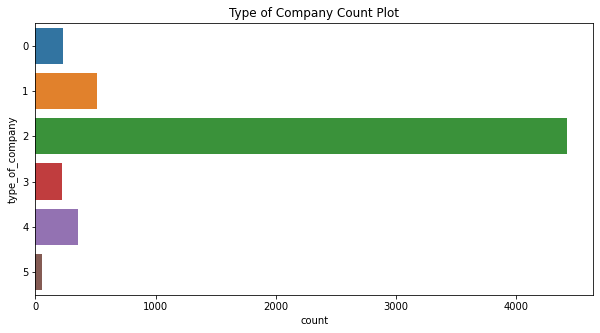

In [71]:
plt.figure(figsize=(10, 5))
sns.countplot(y="type_of_company", data=cleaned_df, orient="h").set(
    title="Type of Company Count Plot", ylabel="type_of_company"
)
plt.show()

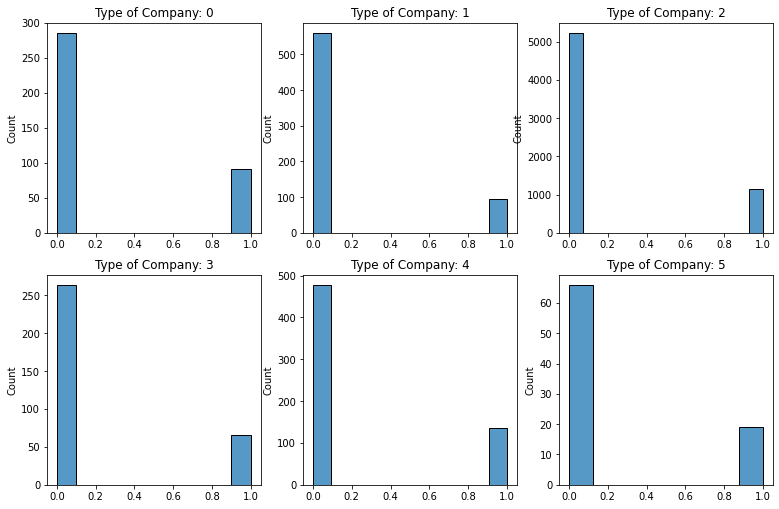

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(13,8.5))
for i, ax in zip(range(0, 6), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.type_of_company == i].willing_to_change_job, ax=ax).set(
        title=f"Type of Company: {i}", xlabel=""
    )
plt.show()

In [50]:
print(job_change_data_train.groupby("is_certified")["willing_to_change_job"].describe())
print(cleaned_df.groupby("is_certified")["willing_to_change_job"].describe())

               count      mean       std  min  25%  50%  75%  max
is_certified                                                     
0             3477.0  0.338798  0.473369  0.0  0.0  0.0  1.0  1.0
1             8950.0  0.213296  0.409658  0.0  0.0  0.0  0.0  1.0
               count      mean       std  min  25%  50%  75%  max
is_certified                                                     
0              686.0  0.209913  0.407543  0.0  0.0  0.0  0.0  1.0
1             5095.0  0.159372  0.366058  0.0  0.0  0.0  0.0  1.0


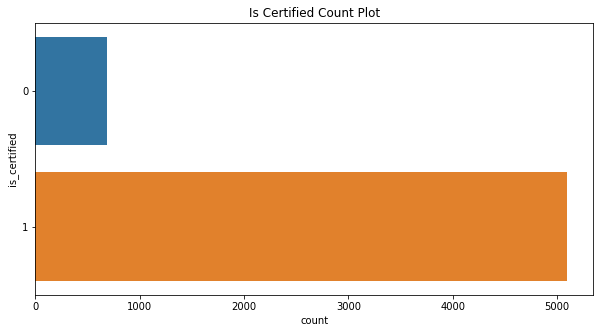

In [73]:
plt.figure(figsize=(10, 5))
sns.countplot(y="is_certified", data=cleaned_df, orient="h").set(
    title="Is Certified Count Plot", ylabel="is_certified"
)
plt.show()

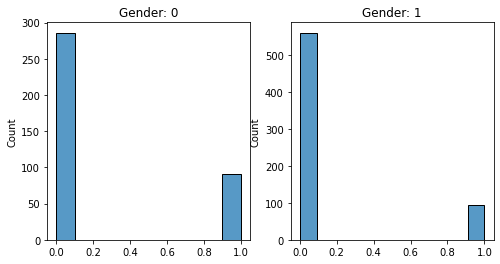

In [19]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
for i, ax in zip(range(0, 3), axes.flat):
    sns.histplot(job_change_data_train[job_change_data_train.type_of_company == i].willing_to_change_job, ax=ax).set(
        title=f"Gender: {i}", xlabel=""
    )
plt.show()

In [65]:
# Identify categorical columns
categorical_columns = cat_col[:-1]

# Cramer's V
def cramers_v(table):
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    min_dim = min(table.shape)
    return np.sqrt(chi2 / (n * (min_dim - 1)))

# Perform tests for all pairs of categorical columns
for col in categorical_columns:
    print(f"\nColumn: {col}")
    # Create contingency table
    contingency_table = pd.crosstab(cleaned_df[col], cleaned_df['willing_to_change_job'])
    
    # Chi-square Test
    chi2_stat, p_val_chi2, _, _ = chi2_contingency(contingency_table)
    print(f"\nChi-square test between '{col}' and 'willing_to_change_job':")
    print("Chi-square test statistic:", chi2_stat)
    print("P-value:", p_val_chi2)
    
    # Cramer's V
    cramers_v_stat = cramers_v(contingency_table.values)
    print("Cramer's V statistic:", cramers_v_stat)
    
    # G-test
    g, p, dof, expctd = chi2_contingency(contingency_table, lambda_="log-likelihood")
    print("G={}; df={}; P={}".format(g, dof, p))


Column: gender

Chi-square test between 'gender' and 'willing_to_change_job':
Chi-square test statistic: 1.8043787708414358
P-value: 0.4056804957715492
Cramer's V statistic: 0.01766698212883192
G=1.7157769712893405; df=2; P=0.424056539126062

Column: education

Chi-square test between 'education' and 'willing_to_change_job':
Chi-square test statistic: 9.77219181713102
P-value: 0.00755084419121792
Cramer's V statistic: 0.04111445207430749
G=10.070842347654892; df=2; P=0.006503458453388135

Column: field_of_studies

Chi-square test between 'field_of_studies' and 'willing_to_change_job':
Chi-square test statistic: 16.47493102897409
P-value: 0.002443807606715
Cramer's V statistic: 0.05338390240489592
G=18.474478146444238; df=4; P=0.0009965541179869366

Column: is_studying

Chi-square test between 'is_studying' and 'willing_to_change_job':
Chi-square test statistic: 47.36005651217593
P-value: 5.1986956981522e-11
Cramer's V statistic: 0.09051167902248845
G=41.9979686556361; df=2; P=7.590265

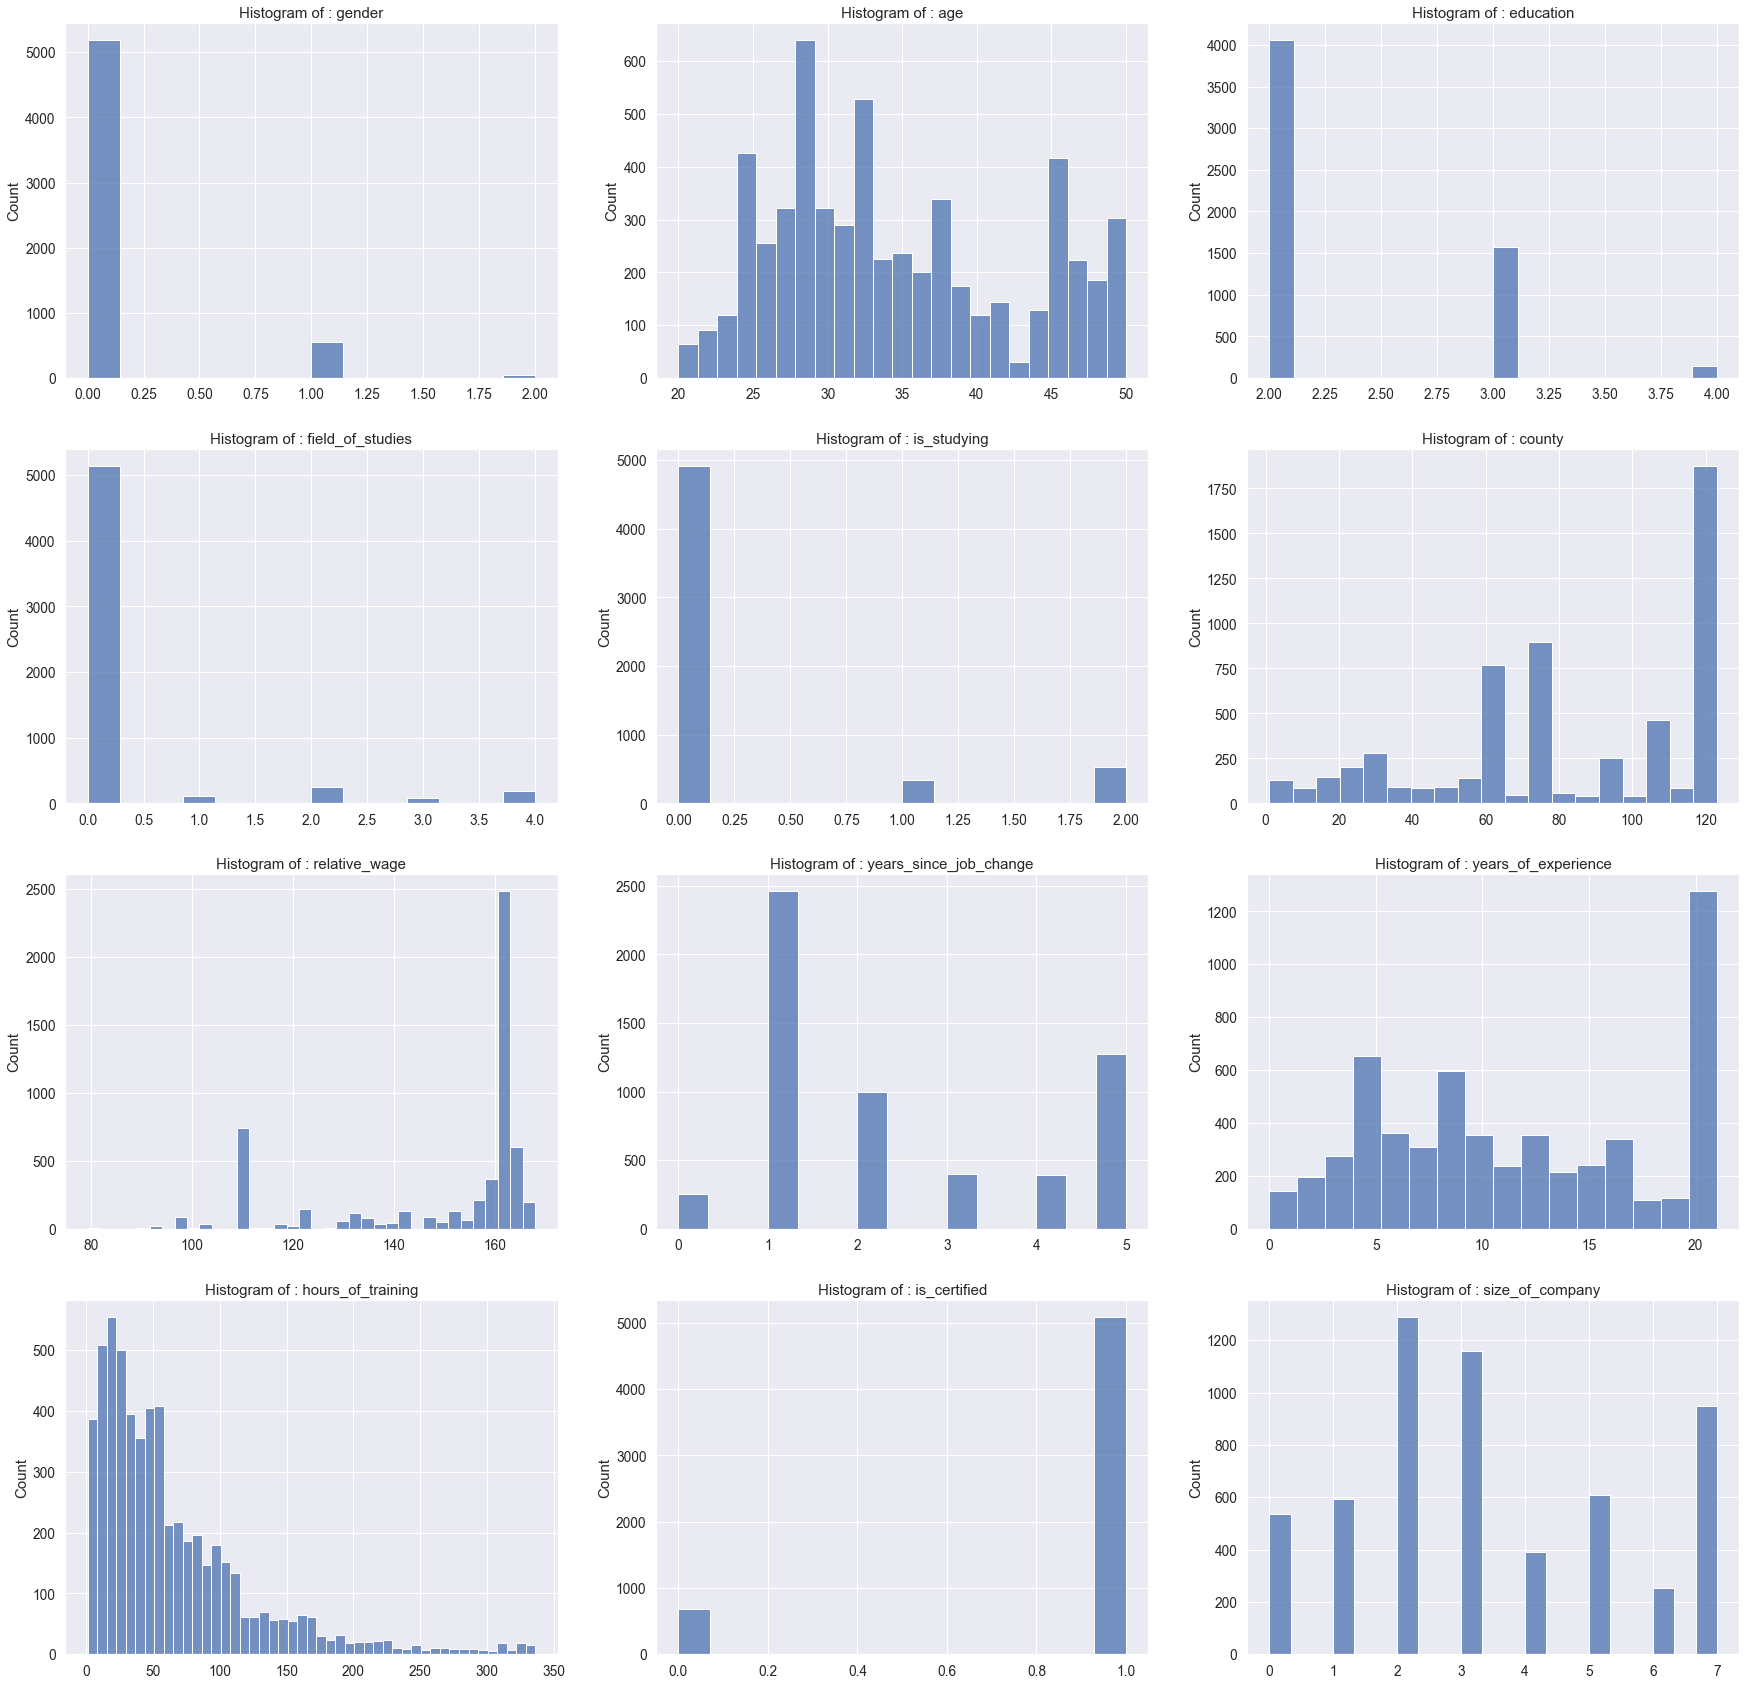

In [90]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(30, 30))
for i, ax in zip(cleaned_df.columns, axes.flat):
    sns.histplot(x=cleaned_df[i], ax=ax).set(title=f"Histogram of : {i}", xlabel="")
plt.show()

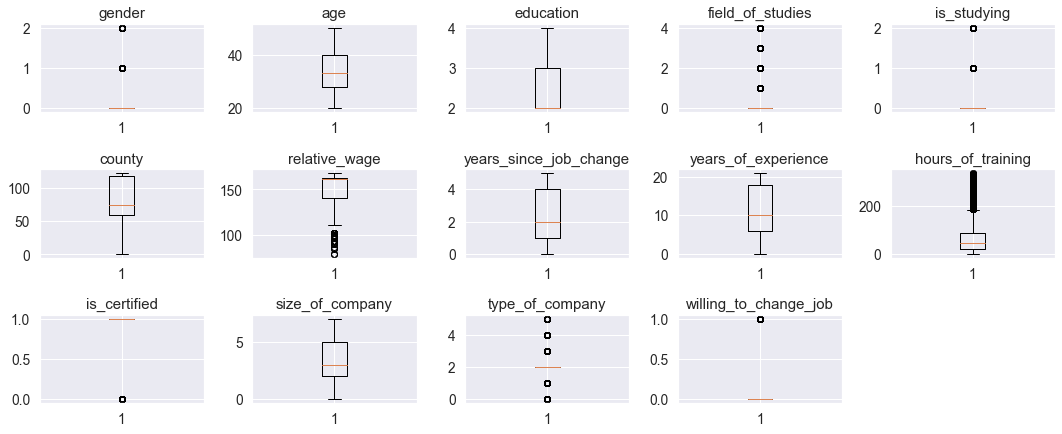

In [93]:
# Select only numerical columns for boxplot
numerical_columns = cleaned_df.select_dtypes(include=['int64', 'float64']).columns

# Plot boxplots for each numerical column
plt.figure(figsize=(15, 10))  # Adjust figure size as needed

for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(5, 5, i)  # Adjust subplot layout based on the number of columns
    plt.boxplot(cleaned_df[column])  # Plot boxplot for each column
    plt.title(column)  # Set title as column name
    plt.grid(True)  # Add grid for better visualization

plt.tight_layout()  # Adjust subplot layout for better spacing
plt.show()

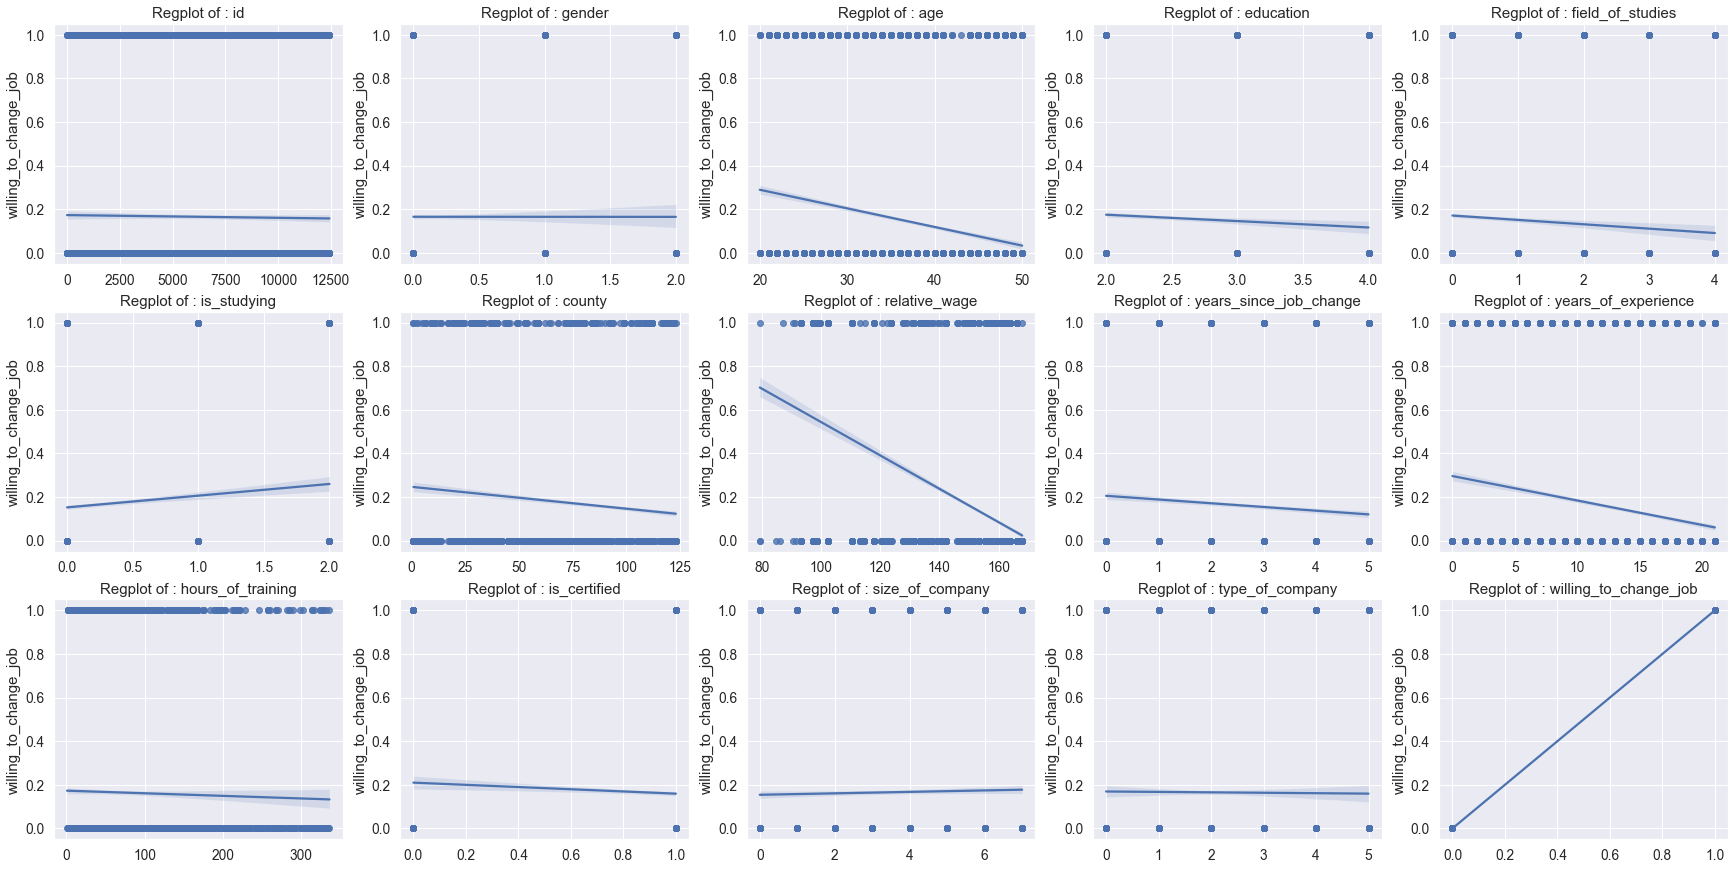

In [84]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(30, 15))
for i, ax in zip(cleaned_df.columns, axes.flat):
    sns.regplot(x=cleaned_df[i], y=cleaned_df["willing_to_change_job"], ax=ax).set(title=f"Regplot of : {i}", xlabel="")
plt.show()

### Correlation of the variables

In [85]:
cleaned_df.corr()

,id,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
id,1.000000,-0.009066,0.007838,0.022180,-0.013331,0.023072,-0.002802,0.015037,-0.016264,0.008533,-0.006705,-0.039388,0.020175,0.007548,-0.011977
gender,-0.009066,1.000000,-0.063759,0.015548,0.073142,-0.010275,0.014055,0.052276,-0.035613,-0.066207,-0.000778,-0.064180,0.008791,0.018116,-0.000205
age,0.007838,-0.063759,1.000000,0.173415,-0.008309,-0.237562,0.116370,0.318188,0.404548,0.966043,0.009237,0.110052,0.081371,0.067331,-0.185006
education,0.022180,0.015548,0.173415,1.000000,-0.029420,-0.063288,-0.007833,0.067257,0.068961,0.177110,-0.001352,-0.050186,0.064235,0.083931,-0.040992
field_of_studies,-0.013331,0.073142,-0.008309,-0.029420,1.000000,-0.047137,0.098689,0.105000,-0.001954,-0.016124,-0.017632,-0.081044,-0.038208,0.032552,-0.047555
is_studying,0.023072,-0.010275,-0.237562,-0.063288,-0.047137,1.000000,-0.069318,-0.135971,-0.143362,-0.251156,0.003382,-0.183465,-0.022994,0.051814,0.087184
county,-0.002802,0.014055,0.116370,-0.007833,0.098689,-0.069318,1.000000,0.338098,0.081747,0.117947,-0.017760,-0.000466,0.089271,0.031960,-0.095677
relative_wage,0.015037,0.052276,0.318188,0.067257,0.105000,-0.135971,0.338098,1.000000,0.185439,0.334635,0.001026,0.005798,0.060476,0.065549,-0.425161
years_since_job_change,-0.016264,-0.035613,0.404548,0.068961,-0.001954,-0.143362,0.081747,0.185439,1.000000,0.420083,-0.009984,0.036152,0.103452,0.122358,-0.076786
years_of_experience,0.008533,-0.066207,0.966043,0.177110,-0.016124,-0.251156,0.117947,0.334635,0.420083,1.000000,0.007968,0.125607,0.081153,0.064641,-0.197980


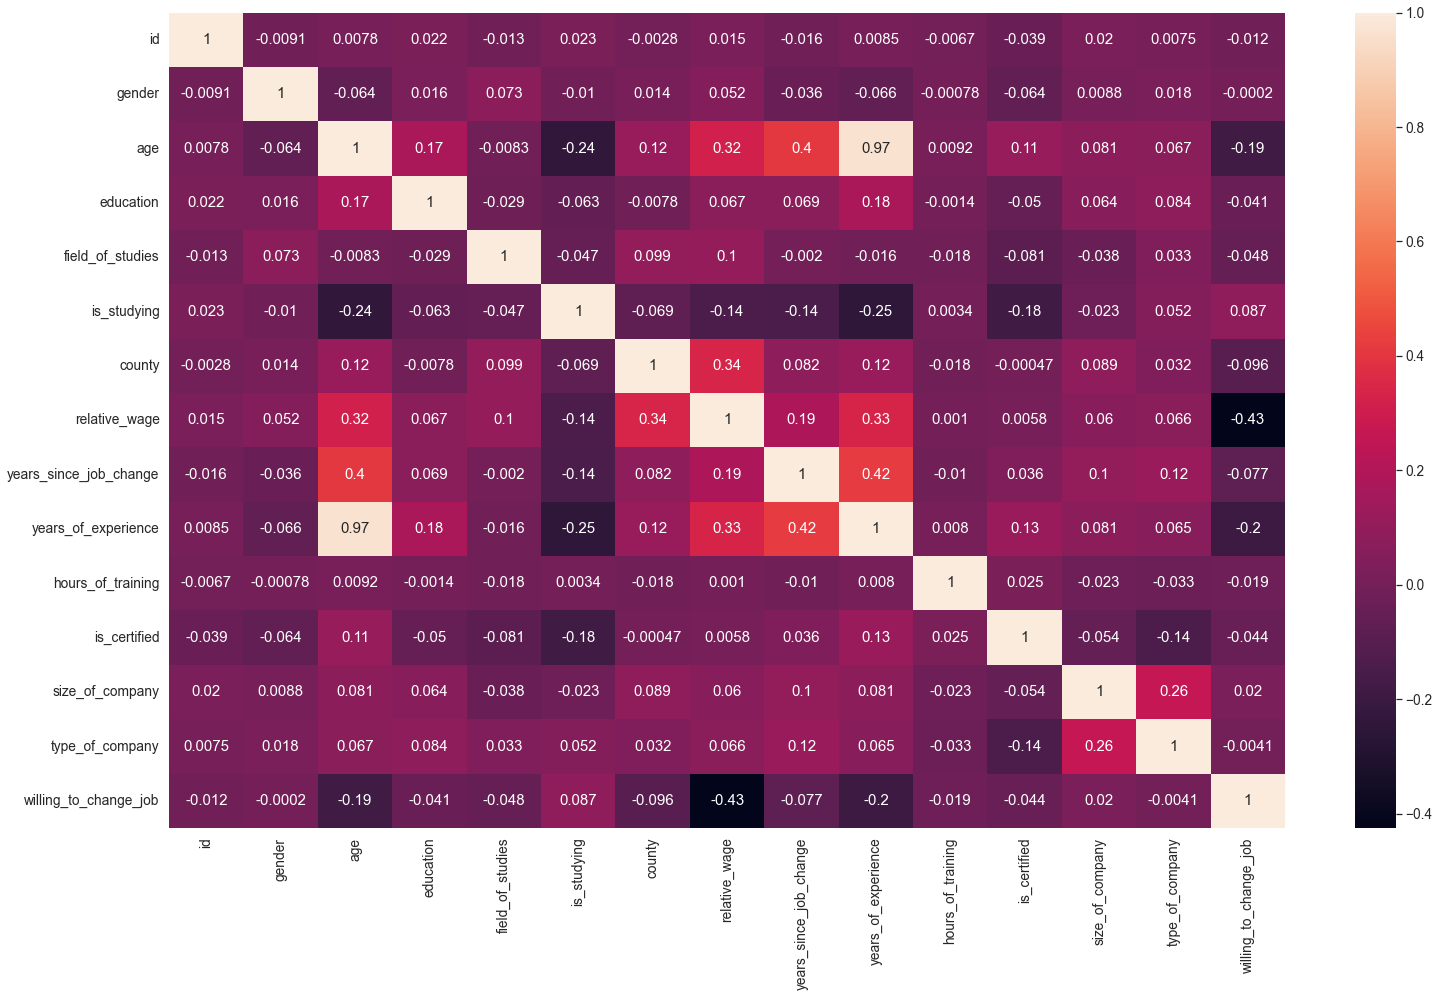

In [86]:
plt.figure(figsize=(25,15))
sns.set(font_scale=1.25)
sns.heatmap(cleaned_df.corr(), annot=True) 
plt.show()

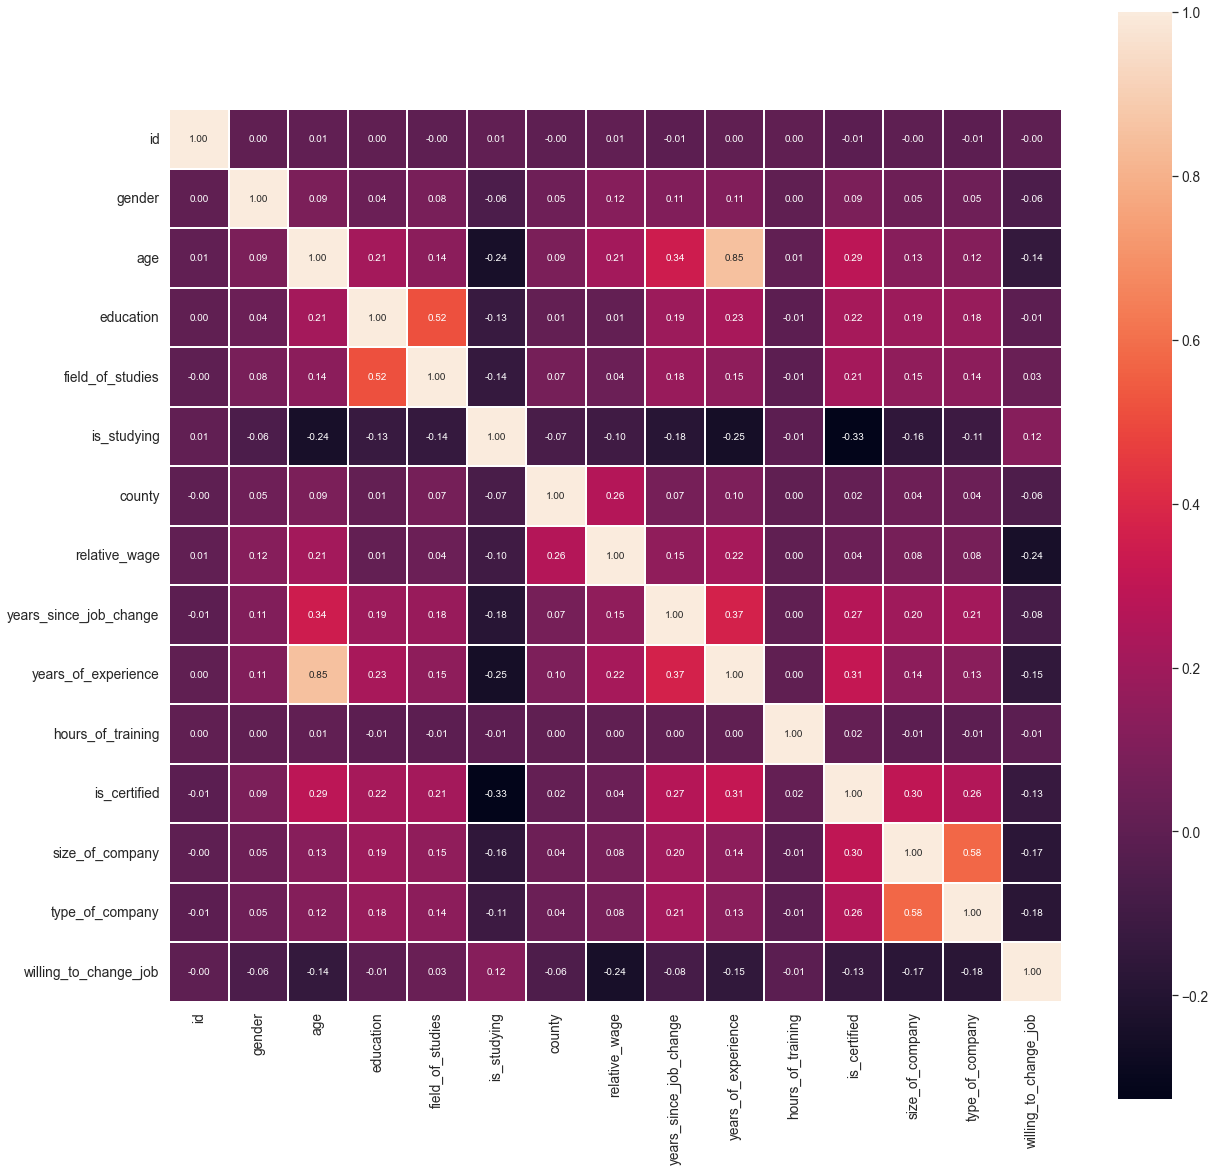

In [87]:
corr = job_change_data_train[cleaned_df.columns].corr("kendall")
plt.figure(figsize=(20, 20))
sns.set(font_scale=1.25)
sns.heatmap(
    corr, linewidths=1.5, annot=True, square=True, fmt=".2f", annot_kws={"size": 10}
)
plt.show()

#### Strong Positive Correlation
- Age and Years of Experience: `age` and `years_of_experience` are positively correlated with each other approximating to `0.96`. This indicates that older individuals tend to have more years of experience and may have spent more time since their last job change.

#### Positive Correlation
- Relative Wage with Age, Years of Experience, County: `relative_wage` shows a positive correlation with `age`, `years_of_experience`, and `county`. This suggests that individuals with higher relative wages tend to be older, have more experience, and come from more specific regions.
- While `age` and `county` show a weak positive correlation of `0.12`, indicating a slight tendency for older individuals to be associated with specific counties, `years_since_job_change` and `age` exhibit a stronger correlation of `0.45`, implying that older individuals tend to stay longer in their current jobs. Furthermore, `age` has moderate positive correlations with both `education (0.241462)` and `is_certified (0.31)`, suggesting that older individuals are more likely to possess higher education levels and certifications compared to their younger counterparts.
- A moderate positive correlation of `0.35` between `education` and `field_of_studies` suggests that individuals with advanced education levels often specialize in particular fields of study. Additionally, `years_since_job_change` shows a positive correlation of `0.2` with `education`, implying that those who have been in their current job longer typically possess higher educational qualifications. Furthermore, `years_of_experience` has a correlation of `0.26` with `education`, indicating that more experienced individuals tend to have higher levels of education. The `is_certified` variable correlates positively with Education at `0.23`, suggesting that certified individuals often have advanced educational backgrounds. Lastly, `size_of_company` and `type_of_company` show weak positive correlations of `0.22` and `0.21`, respectively, with `education`, hinting that individuals with higher educational qualifications might work for larger or specific types of companies.

#### Weak Correlation
- Identifiers like `id` are not informative for predictive modeling as they are unique for each record and don't provide any meaningful information about the target variable.
- The correlation values for `gender`, `hours_of_training`, `is_studying` indicates a very weak correlation with the target variable. This suggests that these features may not significantly influence the willingness to change jobs in the dataset.

In [88]:
# Remove very weakly correlated columns 
columns_to_remove = ['id']
cleaned_df.drop(columns=columns_to_remove, inplace=True)
cleaned_df

d:\hp\ayeti\pl\python\python 3.9\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,gender,age,education,field_of_studies,is_studying,county,relative_wage,years_since_job_change,years_of_experience,hours_of_training,is_certified,size_of_company,type_of_company,willing_to_change_job
0,0,22,2,0,0,118,162.84,1,2,18,1,0,2,0
1,0,27,2,0,0,28,151.34,1,6,24,1,2,2,0
2,0,38,2,0,0,31,114.17,1,13,96,1,2,1,0
4,0,28,2,0,0,118,162.84,1,5,106,1,5,2,0
5,0,25,2,0,0,59,110.45,1,3,43,1,7,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12420,0,39,2,0,2,59,110.45,2,16,35,1,3,2,0
12423,0,31,2,0,0,59,110.45,1,7,116,1,7,2,1
12424,0,47,4,0,0,118,162.84,0,21,144,1,0,2,0
12425,0,24,2,0,0,59,110.45,0,5,100,1,2,2,0


In [94]:
from scipy.stats import zscore
import numpy as np

# Using z-score to rmove outliers
z_scores = zscore(cleaned_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

cleaned_df = cleaned_df[filtered_entries]

In [96]:
round(cleaned_df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
gender,5132.0,0.09,0.29,0.00,0.00,0.00,0.00,1.00
age,5132.0,34.31,7.95,20.00,28.00,33.00,40.00,50.00
education,5132.0,2.29,0.45,2.00,2.00,2.00,3.00,3.00
field_of_studies,5132.0,0.11,0.43,0.00,0.00,0.00,0.00,2.00
is_studying,5132.0,0.25,0.61,0.00,0.00,0.00,0.00,2.00
county,5132.0,80.70,35.30,1.00,59.00,75.00,118.00,123.00
relative_wage,5132.0,148.90,20.85,90.62,135.76,161.07,162.84,167.97
years_since_job_change,5132.0,2.34,1.67,0.00,1.00,2.00,4.00,5.00
years_of_experience,5132.0,11.50,6.48,0.00,6.00,10.00,17.00,21.00
hours_of_training,5132.0,59.17,48.75,1.00,22.00,46.00,83.00,242.00


In [97]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define features and target variable
features = ['age', 'education', 'field_of_studies', 'county', 'relative_wage', 
            'years_since_job_change', 'years_of_experience', 'is_certified', 
            'size_of_company', 'type_of_company']
target = 'willing_to_change_job'

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df[features], 
                                                      cleaned_df[target], 
                                                      test_size=0.2, 
                                                      random_state=4)

# List of classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "K-NN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier()
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = clf.predict(X_valid)
    
    # Calculate accuracy and balanced accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
    
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{name} Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
    
    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_valid, y_pred))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    print("="*50)

Training Logistic Regression...
Logistic Regression Accuracy: 83.74%
Logistic Regression Balanced Accuracy: 59.40%
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       859
           1       0.51      0.23      0.32       168

    accuracy                           0.84      1027
   macro avg       0.69      0.59      0.61      1027
weighted avg       0.81      0.84      0.81      1027

Confusion Matrix:
[[821  38]
 [129  39]]
Training Decision Tree...
Decision Tree Accuracy: 77.70%
Decision Tree Balanced Accuracy: 62.01%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       859
           1       0.34      0.39      0.36       168

    accuracy                           0.78      1027
   macro avg       0.61      0.62      0.61      1027
weighted avg       0.79      0.78      0.78      1027


C:\Users\HP\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Confusion Matrix:
[[733 126]
 [103  65]]
Training Random Forest...
Random Forest Accuracy: 84.52%
Random Forest Balanced Accuracy: 65.37%
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       859
           1       0.54      0.37      0.44       168

    accuracy                           0.85      1027
   macro avg       0.71      0.65      0.67      1027
weighted avg       0.83      0.85      0.83      1027

Confusion Matrix:
[[806  53]
 [106  62]]
Training Gradient Boosting...
Gradient Boosting Accuracy: 85.30%
Gradient Boosting Balanced Accuracy: 70.14%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       859
           1       0.56      0.48      0.51       168

    accuracy                           0.85      1027
   macro avg       0.73      0.70      0.71      1027
weighted avg       0.84      0.85      0.85      1027

Confusion M

In [98]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Define features and target variable
features = ['age', 'education', 'field_of_studies', 'county', 'relative_wage', 
            'years_since_job_change', 'years_of_experience', 'is_certified', 
            'size_of_company', 'type_of_company']
target = 'willing_to_change_job'

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(cleaned_df[features], 
                                                      cleaned_df[target], 
                                                      test_size=0.2, 
                                                      random_state=4)

# List of classifiers
classifiers = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "LightGBM": LGBMClassifier()
}

# Define the parameter grid for each classifier
param_grids = {
    "Gradient Boosting": {'n_estimators': [50, 100, 200, 30],'learning_rate': [0.01, 0.05, 0.1, 0.19], 'max_depth': [3, 5, 7]},
    "LightGBM": {'learning_rate': [0.008,0.099,0.0009,0.009,0.007,0.005], 'n_estimators': [275, 250,225]}
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"Tuning {name}...")
    param_grid = param_grids[name]
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    # Predict on validation set with best parameters
    best_clf = grid_search.best_estimator_
    y_pred = best_clf.predict(X_valid)
    
    # Calculate accuracy and balanced accuracy
    accuracy = accuracy_score(y_valid, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_valid, y_pred)
    
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")
    print(f"{name} Balanced Accuracy: {balanced_accuracy * 100:.2f}%")
    
    # Generate classification report
    print("Classification Report:")
    print(classification_report(y_valid, y_pred))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_valid, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    print("="*50)


Tuning Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
Gradient Boosting Accuracy: 85.20%
Gradient Boosting Balanced Accuracy: 70.08%
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91       859
           1       0.56      0.48      0.51       168

    accuracy                           0.85      1027
   macro avg       0.73      0.70      0.71      1027
weighted avg       0.84      0.85      0.85      1027

Confusion Matrix:
[[795  64]
 [ 88  80]]
Tuning LightGBM...
[LightGBM] [Info] Number of positive: 698, number of negative: 3407
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 249
[LightGBM] [Info] Number of data points in the train set:

[LightGBM] [Info] Number of positive: 77, number of negative: 333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 157
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187805 -> initscore=-1.464337
[LightGBM] [Info] Start training from score -1.464337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 359, number of negative: 1693
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174951 -> initscore=-1.550935
[LightGBM] [Info] Start training from score -1.550935
[LightGBM] [Info] Number of positive: 499, number of negative: 2374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 227
[LightGBM] [Info] Number of data points in the train set: 2873, number of used features: 10
[LightGBM] [Info] [binary:Bo

[LightGBM] [Info] Number of positive: 358, number of negative: 1694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 219
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174464 -> initscore=-1.554315
[LightGBM] [Info] Start training from score -1.554315
[LightGBM] [Info] Number of positive: 498, number of negative: 2375
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 235
[LightGBM] [Info] Number of data points in the train set: 2873, number of used features: 10
[LightGBM] [Info] [binary:Bo

[LightGBM] [Info] Number of positive: 347, number of negative: 1705
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169103 -> initscore=-1.591996
[LightGBM] [Info] Start training from score -1.591996
[LightGBM] [Info] Number of positive: 499, number of negative: 2374
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 2873, number of used features: 10
[LightGBM] [Info] [binary:Bo

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174464 -> initscore=-1.554315
[LightGBM] [Info] Start training from score -1.554315
[LightGBM] [Info] Number of positive: 494, number of negative: 2379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 2873, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.171946 -> initscore=-1.571900
[LightGBM] [Info

[LightGBM] [Info] Number of positive: 358, number of negative: 1694
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 217
[LightGBM] [Info] Number of data points in the train set: 2052, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.174464 -> initscore=-1.554315
[LightGBM] [Info] Start training from score -1.554315
[LightGBM] [Info] Number of positive: 494, number of negative: 2379
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 2873, number of used features: 10
[LightGBM] [Info] [binary:Bo

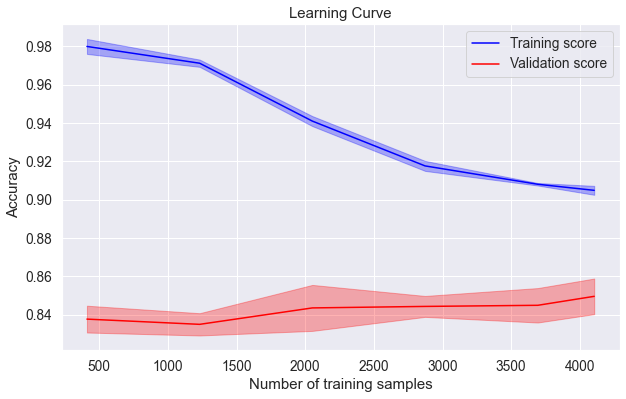

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Define the features and target variable
features = ['age', 'education', 'field_of_studies', 'county', 'relative_wage', 'years_since_job_change', 
            'years_of_experience', 'is_certified', 'size_of_company', 'type_of_company']
target = 'willing_to_change_job'

# Define Random Forest Classifier
clf = LGBMClassifier(random_state=123)

# Create learning curve
train_sizes, train_scores, valid_scores = learning_curve(clf, 
                                                         cleaned_df[features], 
                                                         cleaned_df[target], 
                                                         train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0], 
                                                         cv=5)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.3)
plt.plot(train_sizes, valid_mean, label='Validation score', color='red')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color='red', alpha=0.3)
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()
